## Предсказание объемов продаж на ограниченом объеме

In [2]:
%pylab inline
%matplotlib inline

import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

from sklearn import svm
from sklearn import metrics
from sklearn import grid_search
from sklearn import preprocessing

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.grid_search import GridSearchCV

from sklearn.linear_model import SGDRegressor

import xgboost as xgb

from sklearn.cross_validation import StratifiedKFold, train_test_split
from sklearn.metrics import auc, mean_squared_error, log_loss, roc_auc_score, zero_one_loss, accuracy_score, precision_score, recall_score

from hyperopt import hp, tpe, STATUS_OK, Trials, rand
from hyperopt import fmin as fminHyper

import MySQLdb

from math import ceil

from datetime import timedelta
import datetime

Populating the interactive namespace from numpy and matplotlib


C:\Anaconda\lib\site-packages\IPython\core\magics\pylab.py:161: UserWarning: pylab import has clobbered these variables: ['ceil', 'rand']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [3]:
def check_for_holidays4(date):
    if (date == pd.DatetimeIndex(['2014-03-08 00:00:00'])[0].dayofyear 
        or date == pd.DatetimeIndex(['2014-02-23 00:00:00'])[0].dayofyear 
        or date == pd.DatetimeIndex(['2014-01-07 00:00:00'])[0].dayofyear 
        or date == pd.DatetimeIndex(['2014-05-20 00:00:00'])[0].dayofyear 
       or date == pd.DatetimeIndex(['2014-05-27 00:00:00'])[0].dayofyear 
        or date == pd.DatetimeIndex(['2014-06-12 00:00:00'])[0].dayofyear 
        or date == pd.DatetimeIndex(['2014-11-05 00:00:00'])[0].dayofyear 
       ):
        return 1
    if (date == pd.DatetimeIndex(['2014-01-01 00:00:00'])[0].dayofyear 
        or date == pd.DatetimeIndex(['2014-05-09 00:00:00'])[0].dayofyear):
        return 2
    return 0
    

def check_for_holidays5(date):
    if (date == pd.DatetimeIndex(['2015-03-08 00:00:00'])[0].dayofyear 
        or date == pd.DatetimeIndex(['2015-02-23 00:00:00'])[0].dayofyear 
        or date == pd.DatetimeIndex(['2015-01-07 00:00:00'])[0].dayofyear 
        or date == pd.DatetimeIndex(['2015-05-20 00:00:00'])[0].dayofyear 
       or date == pd.DatetimeIndex(['2015-05-27 00:00:00'])[0].dayofyear 
        or date == pd.DatetimeIndex(['2015-06-12 00:00:00'])[0].dayofyear 
        or date == pd.DatetimeIndex(['2015-11-05 00:00:00'])[0].dayofyear 
       ):
        return 1
    if (date == pd.DatetimeIndex(['2015-01-01 00:00:00'])[0].dayofyear 
        or date == pd.DatetimeIndex(['2015-05-09 00:00:00'])[0].dayofyear):
        return 2
    return 0
    

def check_for_holidays6(date):
    if (date == pd.DatetimeIndex(['2016-03-08 00:00:00'])[0].dayofyear 
        or date == pd.DatetimeIndex(['2016-02-23 00:00:00'])[0].dayofyear 
        or date == pd.DatetimeIndex(['2016-01-07 00:00:00'])[0].dayofyear 
        or date == pd.DatetimeIndex(['2016-05-20 00:00:00'])[0].dayofyear 
       or date == pd.DatetimeIndex(['2016-05-27 00:00:00'])[0].dayofyear 
        or date == pd.DatetimeIndex(['2016-06-12 00:00:00'])[0].dayofyear 
        or date == pd.DatetimeIndex(['2016-11-05 00:00:00'])[0].dayofyear 
       ):
        return 1
    if (date == pd.DatetimeIndex(['2016-01-01 00:00:00'])[0].dayofyear 
        or date == pd.DatetimeIndex(['2016-05-09 00:00:00'])[0].dayofyear):
        return 2
    return 0
    
def check_for_holidays7(date):
    if (date == pd.DatetimeIndex(['2017-03-08 00:00:00'])[0].dayofyear 
        or date == pd.DatetimeIndex(['2017-02-23 00:00:00'])[0].dayofyear 
        or date == pd.DatetimeIndex(['2017-01-07 00:00:00'])[0].dayofyear 
        or date == pd.DatetimeIndex(['2017-05-20 00:00:00'])[0].dayofyear 
        or date == pd.DatetimeIndex(['2017-05-27 00:00:00'])[0].dayofyear 
        or date == pd.DatetimeIndex(['2017-06-12 00:00:00'])[0].dayofyear 
        or date == pd.DatetimeIndex(['2017-11-05 00:00:00'])[0].dayofyear 
       ):
        return 1
    if (date == pd.DatetimeIndex(['2017-01-01 00:00:00'])[0].dayofyear 
        or date == pd.DatetimeIndex(['2017-05-09 00:00:00'])[0].dayofyear):
        return 2
    return 0

**Загрузка данных**

In [ ]:
%%time
db_connection = MySQLdb.connect(host="194.247.15.117", 
                     port=7806,
                     user="bar",
                     passwd="PASSWORD",
                     db="Inventory")

data = pd.read_sql('SELECT * FROM Inventory.vTotalPassengers_v2', con=db_connection)
db_connection.close()

print(len(data))

In [ ]:
data.sort_values(by=['FlightID', 'DptDt'], inplace=True)
data.drop(data.index[data.fltNrDptDt > datetime.date(2017, 3, 31)], axis = 0, inplace = True)
data.tail(25)

**Предобработка данных**

In [49]:
# drop stuff
data.drop('reportDt', axis = 1, inplace = True)
data.drop('seatsAvail', axis = 1, inplace = True)
data.drop('authLevel', axis = 1, inplace = True)
data.drop('Carrier', axis = 1, inplace = True)

In [50]:
# make flight id 
data['flightNrSf'] = [str(data.fltNr.values[x]) + data.opsSuffix.values[x] for x in range(0, len(data.fltNr.values))]
data.drop('fltNr', axis = 1, inplace = True)
data.drop('opsSuffix', axis = 1, inplace = True)

In [61]:
# словари для кодирования позедов, сегментов и классов вагонов
segment_dict = dict(enumerate(set(np.append(data.orig.unique(), data.dest.unique()))))
flightNrSf_dict = dict(enumerate(data.flightNrSf.unique()))
code_dict = dict(enumerate(data.Code.unique()))

# кодируем сегмент
data.orig = data.orig.map(lambda x: list(segment_dict.keys())[list(segment_dict.values()).index(x)])
data.dest = data.dest.map(lambda x: list(segment_dict.keys())[list(segment_dict.values()).index(x)])

# кодируем поезда
data.flightNrSf = data.flightNrSf.map(lambda x: list(flightNrSf_dict.keys())[list(flightNrSf_dict.values()).index(x)])

# кодируем вагоны
data.Code = data.Code.map(lambda x: list(code_dict.keys())[list(code_dict.values()).index(x)])

In [67]:
# make segment
data['segment'] = data.orig.astype('str') + '_' + data.dest.astype('str')
data.drop('orig', axis = 1, inplace = True)
data.drop('dest', axis = 1, inplace = True)

In [84]:
# drop bad segments
jig_flight = (6, 7)
keep_segments = set(np.append(data.segment[data.flightNrSf == jig_flight[0]].unique(), data.segment[data.flightNrSf == jig_flight[1]].unique()))

drop_indexes = list()
for segment in data.segment.unique():
    if segment not in keep_segments:
        drop_indexes = np.append(drop_indexes, data[data.segment == segment].index.values)

data.drop(drop_indexes, axis = 0, inplace = True)

In [103]:
# словарь для повторного кодирования сегментов
segment_sec_dict = dict(enumerate(data.segment.unique()))

# повторно кодируем сегмент
data.segment = data.segment.map(lambda x: list(segment_sec_dict.keys())[list(segment_sec_dict.values()).index(x)])

In [95]:
# make date
data.DptDt = pd.DatetimeIndex(data.DptDt)
data.fltNrDptDt = pd.DatetimeIndex(data.fltNrDptDt)
data.fltNrArrDt = pd.DatetimeIndex(data.fltNrArrDt)

In [15]:
# сделать в разрезе сегмента - номера поезда - типа вагона, проверить точность с и без
# for flightID in unique(data.FlightID):
#     for code in unique(data.Code[data.FlightID == flightID]):
#         for segment in unique(data.segment[data.FlightID == flightID][data.Code == code]):
#             sigma3 = np.mean(data.resHoldTotal[data.FlightID == flightID][data.Code == code][data.segment == segment].values) + 3 * np.std(data.resHoldTotal[data.FlightID == flightID][data.Code == code][data.segment == segment].values)
#             data.drop(data[data.resHoldTotal > sigma3][data.FlightID == flightID][data.Code == code][data.segment == segment].index, axis = 0, inplace = True)

In [188]:
data.reset_index(inplace=True)
data.drop('index', axis = 1, inplace = True)
data

,FlightID,Code,fltNrDptDt,DptTime,ArrTime,flightNrSf,segment,DayOfWeekDpt,WeekOfMonth,MonthDpt,QuarterDpt,YearDpt,DayOfWeeArr,WeekOfMonthArr,MonthArr,QuarterArr,YearArr,Holiday
0,251371,0,2014-02-27,18,1,0,0,3,5,2,1,2014,4,5,2,1,2014,0
1,251371,1,2014-02-27,18,1,0,0,3,5,2,1,2014,4,5,2,1,2014,0
2,251371,2,2014-02-27,18,1,0,0,3,5,2,1,2014,4,5,2,1,2014,0
3,251371,0,2014-02-27,18,5,0,1,3,5,2,1,2014,4,5,2,1,2014,0
4,251371,1,2014-02-27,18,5,0,1,3,5,2,1,2014,4,5,2,1,2014,0
5,251371,2,2014-02-27,18,5,0,1,3,5,2,1,2014,4,5,2,1,2014,0
6,251371,0,2014-02-27,18,7,0,2,3,5,2,1,2014,4,5,2,1,2014,0
7,251371,1,2014-02-27,18,7,0,2,3,5,2,1,2014,4,5,2,1,2014,0
8,251371,2,2014-02-27,18,7,0,2,3,5,2,1,2014,4,5,2,1,2014,0
9,251371,0,2014-02-27,1,5,0,3,4,5,2,1,2014,4,5,2,1,2014,0


**Обогащение данных**

In [97]:
# дата

def week_of_month(dt):
    first_day = dt.replace(day=1)
    dom = dt.day
    adjusted_dom = dom + first_day.weekday()
    return int(ceil(adjusted_dom/7.0))

data['DayOfWeekDpt'] = pd.DatetimeIndex(data['DptDt']).dayofweek 
data['WeekOfMonth'] = [week_of_month(x) for x in pd.DatetimeIndex(data['DptDt'])]
data['MonthDpt'] = pd.DatetimeIndex(data['DptDt']).month 
data['QuarterDpt'] = pd.DatetimeIndex(data['DptDt']).quarter 
data['YearDpt'] = pd.DatetimeIndex(data['DptDt']).year

data['DayOfWeeArr'] = pd.DatetimeIndex(data['fltNrArrDt']).dayofweek 
data['WeekOfMonthArr'] = [week_of_month(x) for x in pd.DatetimeIndex(data['fltNrArrDt'])]
data['MonthArr'] = pd.DatetimeIndex(data['fltNrArrDt']).month 
data['QuarterArr'] = pd.DatetimeIndex(data['fltNrArrDt']).quarter 
data['YearArr'] = pd.DatetimeIndex(data['fltNrArrDt']).year

In [194]:
# праздники
data['Holiday'] = 0
for date in data.fltNrDptDt.unique():
    if (check_for_holidays4(pd.DatetimeIndex([date]).dayofyear) == 1 or check_for_holidays5(pd.DatetimeIndex([date]).dayofyear) == 1 or check_for_holidays6(pd.DatetimeIndex([date]).dayofyear) == 1 or check_for_holidays7(pd.DatetimeIndex([date]).dayofyear) == 1):
        
        data.iloc[data[data['fltNrDptDt'] == date].index.values,  list(data.columns.values).index('Holiday') ] = 1
        
#         for index in data[data['fltNrDptDt'] == date].index.values:
#             data.iloc[index,  list(data.columns.values).index('Holiday') ] = 1
#             data.iloc[index - data.index[0] - 7 : index - data.index[0] + 8, list(data.columns.values).index('Holiday') ] = np.append(np.arange(1, 9), np.arange(1, 8)[::-1])
            
#         data['Holiday'][data[data['DptDt'] == date].index.values] = 8
#         days_before_holidays = 7
#         index = data[data['DptDt'] == date].index.values[0] - 1
#         while (index >=0 and days_before_holidays >= 0):
#             data['Holiday'][index] = days_before_holidays
#             days_before_holidays -= 1
#             index -= 1
            
#         days_after_holidays = 7
#         index = data[data['DptDt'] == date].index.values[0] + 1
#         while (days_after_holidays >= 0 and index <= len(data['Holiday'])):
#             data['Holiday'][index] = days_after_holidays
#             days_after_holidays -= 1
#             index += 1
        
        
    elif (check_for_holidays4(pd.DatetimeIndex([date]).dayofyear) == 2 or check_for_holidays5(pd.DatetimeIndex([date]).dayofyear) == 2 or check_for_holidays6(pd.DatetimeIndex([date]).dayofyear) == 2 or check_for_holidays7(pd.DatetimeIndex([date]).dayofyear) == 2):
        
        data.iloc[data[data['fltNrDptDt'] == date].index.values,  list(data.columns.values).index('Holiday') ] = 2
        
#         for index in data[data['fltNrDptDt'] == date].index.values:
#             data.iloc[index,  list(data.columns.values).index('Holiday') ] = 2
#             data.iloc[index - data.index[0] - 14 : index - data.index[0] + 15, list(data.columns.values).index('Holiday') ] = np.append(np.arange(1, 16), np.arange(1, 15)[::-1])

#         data['Holiday'][data[data['DptDt'] == date].index.values] = 15
#         days_before_holidays = 14
#         index = data[data['DptDt'] == date].index.values[0] - 1
#         while (index >=0 and days_before_holidays >= 0):
#             data['Holiday'][index] = days_before_holidays
#             days_before_holidays -= 1
#             index -= 1
            
#         days_after_holidays = 14
#         index = data[data['DptDt'] == date].index.values[0] + 1
#         while (days_after_holidays >= 0  and index <= len(data['Holiday'])) :
#             data['Holiday'][index] = days_after_holidays
#             days_after_holidays -= 1
#             index += 1

In [196]:
data[data.Holiday != 0]['fltNrDptDt'].unique()

array(['2014-03-08T00:00:00.000000000', '2014-03-09T00:00:00.000000000',
       '2014-05-09T00:00:00.000000000', '2014-05-10T00:00:00.000000000',
       '2014-05-20T00:00:00.000000000', '2014-05-21T00:00:00.000000000',
       '2014-05-27T00:00:00.000000000', '2014-05-28T00:00:00.000000000',
       '2014-06-12T00:00:00.000000000', '2014-06-13T00:00:00.000000000',
       '2014-11-05T00:00:00.000000000', '2014-11-06T00:00:00.000000000',
       '2015-01-01T00:00:00.000000000', '2015-01-07T00:00:00.000000000',
       '2015-02-23T00:00:00.000000000', '2015-03-08T00:00:00.000000000',
       '2015-03-09T00:00:00.000000000', '2015-05-09T00:00:00.000000000',
       '2015-05-10T00:00:00.000000000', '2015-05-20T00:00:00.000000000',
       '2015-05-21T00:00:00.000000000', '2015-05-27T00:00:00.000000000',
       '2015-05-28T00:00:00.000000000', '2015-06-12T00:00:00.000000000',
       '2015-06-13T00:00:00.000000000', '2015-11-05T00:00:00.000000000',
       '2015-11-06T00:00:00.000000000', '2016-01-01

In [ ]:
# # среднее по поездам / классам за все время - поменять логику на сегменты - 
# data['MeanResHoldTotalAll'] = 0.0
# data['MeanResHoldTotalYear'] = 0.0
# for flightNrSf in unique(data.flightNrSf.values):
#     for segment in unique(data.segment[data.flightNrSf == flightNrSf].values):
#         for code in unique(data.Code[data.flightNrSf == flightNrSf][data.segment == segment].values):
#             data['MeanResHoldTotalAll'][data[data.Code == code][data.flightNrSf == flightNrSf][data.segment == segment].index.values] = mean(data['resHoldTotal'][data.Code == code][data.flightNrSf == flightNrSf][data.segment == segment].values)
#             data['MeanResHoldTotalYear'][data[data.Code == code][data.flightNrSf == flightNrSf][data.segment == segment][data.fltNrDptDt < datetime.date(2015, 1, 1)].index.values] = mean(data['resHoldTotal'][data.Code == code][data.flightNrSf == flightNrSf][data.segment == segment][data.fltNrDptDt < datetime.date(2015, 1, 1)].values)
#             data['MeanResHoldTotalYear'][data[data.Code == code][data.flightNrSf == flightNrSf][data.segment == segment][data.fltNrDptDt < datetime.date(2016, 1, 1)].index.values] = mean(data['resHoldTotal'][data.Code == code][data.flightNrSf == flightNrSf][data.segment == segment][data.fltNrDptDt < datetime.date(2016, 1, 1)].values)
#             data['MeanResHoldTotalYear'][data[data.Code == code][data.flightNrSf == flightNrSf][data.segment == segment][data.fltNrDptDt < datetime.date(2017, 1, 1)].index.values] = mean(data['resHoldTotal'][data.Code == code][data.flightNrSf == flightNrSf][data.segment == segment][data.fltNrDptDt < datetime.date(2017, 1, 1)].values)
#             data['MeanResHoldTotalYear'][data[data.Code == code][data.flightNrSf == flightNrSf][data.segment == segment][data.fltNrDptDt < datetime.date(2018, 1, 1)].index.values] = mean(data['resHoldTotal'][data.Code == code][data.flightNrSf == flightNrSf][data.segment == segment][data.fltNrDptDt < datetime.date(2018, 1, 1)].values)
            

C:\Anaconda\lib\site-packages\ipykernel\__main__.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Anaconda\lib\site-packages\ipykernel\__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda\lib\site-packages\numpy\core\_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
C:\Anaconda\lib\site-packages\ipykernel\__main__.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Anaconda\lib\site-packages\ipykernel\__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda\lib\site-packages\ipykernel\__main__.p

In [197]:
# y
# data['resHoldTotal'] = y
y = data.resHoldTotal.copy()
data.drop('resHoldTotal', axis = 1, inplace = True)

AttributeError: 'DataFrame' object has no attribute 'resHoldTotal'

In [ ]:
# # label encoder
# for f in data.columns:
#     if data[f].dtype=='object':
#         lbl = preprocessing.LabelEncoder()
#         lbl.fit(list(data[f].values))
#         data[f] = lbl.transform(list(data[f].values))

In [198]:
data.head(50)

,FlightID,Code,fltNrDptDt,DptTime,ArrTime,flightNrSf,segment,DayOfWeekDpt,WeekOfMonth,MonthDpt,QuarterDpt,YearDpt,DayOfWeeArr,WeekOfMonthArr,MonthArr,QuarterArr,YearArr,Holiday
0,251371,0,2014-02-27,18,1,0,0,3,5,2,1,2014,4,5,2,1,2014,0
1,251371,1,2014-02-27,18,1,0,0,3,5,2,1,2014,4,5,2,1,2014,0
2,251371,2,2014-02-27,18,1,0,0,3,5,2,1,2014,4,5,2,1,2014,0
3,251371,0,2014-02-27,18,5,0,1,3,5,2,1,2014,4,5,2,1,2014,0
4,251371,1,2014-02-27,18,5,0,1,3,5,2,1,2014,4,5,2,1,2014,0
5,251371,2,2014-02-27,18,5,0,1,3,5,2,1,2014,4,5,2,1,2014,0
6,251371,0,2014-02-27,18,7,0,2,3,5,2,1,2014,4,5,2,1,2014,0
7,251371,1,2014-02-27,18,7,0,2,3,5,2,1,2014,4,5,2,1,2014,0
8,251371,2,2014-02-27,18,7,0,2,3,5,2,1,2014,4,5,2,1,2014,0
9,251371,0,2014-02-27,1,5,0,3,4,5,2,1,2014,4,5,2,1,2014,0


In [107]:
data.drop('fltNrArrDt', axis = 1, inplace = True)
data.drop('DptDt', axis = 1, inplace = True)
# data.drop('Holiday', axis = 1, inplace = True)

In [199]:
X_train = data[:int(len(data) * 0.95)]
X_test = data[int(len(data) * 0.95):]
y_train = y[:int(len(data) * 0.95)]
y_test = y[int(len(data) * 0.95):]

dtrain = xgb.DMatrix(X_train.drop("FlightID", axis = 1).drop("fltNrDptDt", axis = 1), y_train)
dvalid = xgb.DMatrix(X_test.drop("FlightID", axis = 1).drop("fltNrDptDt", axis = 1), y_test)

**Регрессия**

In [84]:
from sklearn.linear_model import Ridge
X_ridge = X_train.copy()
X_ridge['Amount'] = y_train
X_ridge.drop('FlightID', axis = 1, inplace = True)
X_ridge.drop('fltNrDptDt', axis = 1, inplace = True)
X_ridge.drop('DptTime', axis = 1, inplace = True)
X_ridge.drop('ArrTime', axis = 1, inplace = True)
X_ridge.drop('DayOfWeekDpt', axis = 1, inplace = True)
X_ridge.drop('WeekOfMonth', axis = 1, inplace = True)
X_ridge.drop('MonthDpt', axis = 1, inplace = True)
X_ridge.drop('QuarterDpt', axis = 1, inplace = True)
X_ridge.drop('YearDpt', axis = 1, inplace = True)
X_ridge.drop('segment', axis = 1, inplace = True)
X_ridge.head()

,Code,flightNrSf,Amount
280911,3,8,0.0
280833,0,8,0.0
280832,1,8,0.0
280831,3,8,0.0
280830,4,8,0.0


In [85]:
X_ridge_test = X_test.copy() 
X_ridge_test['Amount'] = y_test
X_ridge_test.drop('FlightID', axis = 1, inplace = True)
X_ridge_test.drop('fltNrDptDt', axis = 1, inplace = True)
X_ridge_test.drop('DptTime', axis = 1, inplace = True)
X_ridge_test.drop('ArrTime', axis = 1, inplace = True)
X_ridge_test.drop('DayOfWeekDpt', axis = 1, inplace = True)
X_ridge_test.drop('WeekOfMonth', axis = 1, inplace = True)
X_ridge_test.drop('MonthDpt', axis = 1, inplace = True)
X_ridge_test.drop('QuarterDpt', axis = 1, inplace = True)
X_ridge_test.drop('YearDpt', axis = 1, inplace = True)
X_ridge_test.drop('segment', axis = 1, inplace = True)
X_ridge_test.head()

,Code,flightNrSf,Amount
161873,3,6,3.0
161872,4,6,6.0
161871,5,6,0.0
161892,4,6,1.0
162784,4,7,7.0


In [ ]:
X_train['ridge predictions'] = 0.0
X_test['ridge predictions'] = 0.0
for flightNrSf in X_ridge.flightNrSf.unique():
    for Code in X_ridge.Store[X_ridge.SKU == sku].unique():
        
        dataset_x = X_ridge[X_ridge.SKU == sku][X_ridge.Store == store].copy()
        if (len(dataset_x.index) > 0):
            dataset_y = dataset_x['Amount']
            dataset_x.drop("Amount", axis = 1, inplace = True)
            dataset_x.drop("Store", axis = 1, inplace = True)
            dataset_x.drop("SKU", axis = 1, inplace = True)
            clf = Ridge(fit_intercept=True, alpha=0.1, random_state=0, normalize=False)
            clf.fit(dataset_x, dataset_y) 
            res = clf.predict(dataset_x)
            X_train['ridge predictions'][X_train[X_train.SKU == sku][X_train.Store == store].index.values] = res
      
        dataset_x_test = X_ridge_test[X_ridge_test.SKU == sku][X_ridge_test.Store == store]
        if (len(dataset_x_test.index) > 0):
            dataset_y_test = dataset_x_test['Amount'].copy()
            dataset_x_test.drop("Amount", axis = 1, inplace = True)
            dataset_x_test.drop("Store", axis = 1, inplace = True)
            dataset_x_test.drop("SKU", axis = 1, inplace = True)
            res = clf.predict(dataset_x_test)
            X_test['ridge predictions'][X_test[X_test.SKU == sku][X_test.Store == store].index.values] = res

**Модель**

In [109]:
def score(params):
    print("Training with params:")
    print(params)
    
    num_round = int(params['n_estimators'])    
    del params['n_estimators']
    params['max_depth'] = (int) (params['max_depth'])
    
    model = xgb.train(params, dtrain, num_round)
    
    predictions = model.predict(dvalid).reshape((X_test.shape[0], 1))
    score = mean_squared_error(y_test, predictions)
    
    print("\tScore {0}\n\n".format(score))
    return {'loss': score, 'status': STATUS_OK}

In [110]:
def optimize(trials):

    space = {
    'n_estimators' : 75,
    'eta' : hp.quniform('eta', 0.05, 0.5, 0.025),
    'max_depth' : hp.quniform('max_depth', 4, 40, 2),
    'min_child_weight' : hp.quniform('min_child_weight', 1, 20, 1),
    'subsample' : hp.quniform('subsample', 0.5, 1, 0.25),
    'gamma' : 0,
    'colsample_bytree' : hp.quniform('colsample_bytree', 0.5, 1, 0.25),
    'colsample_bylevel' : hp.quniform('colsample_bylevel', 0.5, 1, 0.25),
    'reg_alpha' : hp.quniform('reg_alpha', 0, 1, 0.25),
    'reg_lambda' : hp.quniform('reg_lambda', 0, 1, 0.25),
    'objective': 'reg:linear',
    'nthread' : 4,
    'silent' : 1
    }
    best = fminHyper(score, space, algo=tpe.suggest, trials=trials, max_evals=75)

    print(best)

In [200]:
%%time
trials = Trials()
optimize(trials)

Training with params:
{'reg_alpha': 0.0, 'reg_lambda': 0.5, 'n_estimators': 75, 'colsample_bylevel': 0.5, 'nthread': 4, 'gamma': 0, 'max_depth': 14.0, 'subsample': 0.75, 'eta': 0.45, 'silent': 1, 'min_child_weight': 12.0, 'objective': 'reg:linear', 'colsample_bytree': 0.5}
	Score 99.63463608656625


Training with params:
{'reg_alpha': 0.0, 'reg_lambda': 0.25, 'n_estimators': 75, 'colsample_bylevel': 0.75, 'nthread': 4, 'gamma': 0, 'max_depth': 34.0, 'subsample': 0.75, 'eta': 0.25, 'silent': 1, 'min_child_weight': 16.0, 'objective': 'reg:linear', 'colsample_bytree': 0.5}
	Score 70.57626569807209


Training with params:
{'reg_alpha': 0.25, 'reg_lambda': 0.25, 'n_estimators': 75, 'colsample_bylevel': 1.0, 'nthread': 4, 'gamma': 0, 'max_depth': 14.0, 'subsample': 0.75, 'eta': 0.125, 'silent': 1, 'min_child_weight': 13.0, 'objective': 'reg:linear', 'colsample_bytree': 0.75}
	Score 51.83590991635874


Training with params:
{'reg_alpha': 0.0, 'reg_lambda': 0.75, 'n_estimators': 75, 'colsample

In [201]:
params = {'reg_alpha': 0.25, 'eta': 0.1, 'subsample': 1.0, 'max_depth': 14, 'colsample_bylevel': 1.0, 'min_child_weight': 12.0, 'reg_lambda': 0.0, 'colsample_bytree': 0.75}

In [202]:
xgbCvResult = xgb.cv(params, dtrain, num_boost_round=500, early_stopping_rounds=25, nfold=10, metrics=["rmse"], verbose_eval=True)

[0]	train-rmse:27.9369+0.0664018	test-rmse:28.035+0.629287
[1]	train-rmse:26.0322+0.753137	test-rmse:26.1895+1.08291
[2]	train-rmse:23.9879+0.826434	test-rmse:24.1902+1.04406
[3]	train-rmse:22.0294+0.891401	test-rmse:22.2749+1.11769
[4]	train-rmse:20.2749+1.03703	test-rmse:20.5479+1.1452
[5]	train-rmse:18.6778+0.989124	test-rmse:18.9877+1.02758
[6]	train-rmse:17.2427+0.957928	test-rmse:17.6033+0.98221
[7]	train-rmse:16.1128+0.749152	test-rmse:16.5265+0.837777
[8]	train-rmse:15.0366+0.758102	test-rmse:15.4977+0.864414
[9]	train-rmse:13.8866+0.670431	test-rmse:14.3893+0.811252
[10]	train-rmse:12.9993+0.553086	test-rmse:13.5548+0.745698
[11]	train-rmse:12.3133+0.622305	test-rmse:12.9192+0.798232
[12]	train-rmse:11.5884+0.516876	test-rmse:12.2519+0.734424
[13]	train-rmse:10.7976+0.447043	test-rmse:11.5117+0.663958
[14]	train-rmse:10.17+0.425009	test-rmse:10.9286+0.69541
[15]	train-rmse:9.68827+0.433374	test-rmse:10.4939+0.723123
[16]	train-rmse:9.2491+0.486698	test-rmse:10.107+0.779912
[17

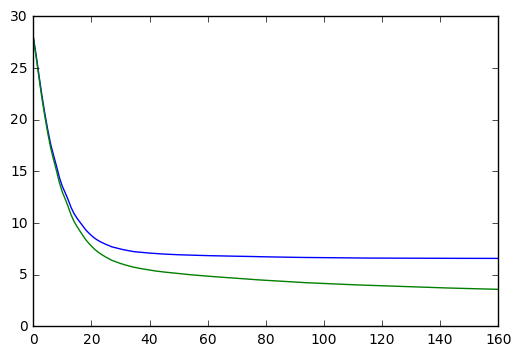

In [203]:
plot(range(xgbCvResult.shape[0]), xgbCvResult['test-rmse-mean'])
plot(range(xgbCvResult.shape[0]), xgbCvResult['train-rmse-mean'])

In [204]:
best_num_round = np.argmin(xgbCvResult['test-rmse-mean'])
# best_num_round = 250
print(best_num_round)

160


**Предсказания**

In [205]:
bestXgb = xgb.train(params, dtrain, best_num_round)

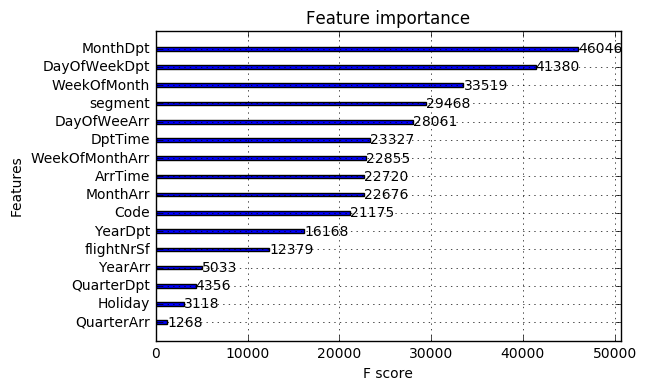

In [206]:
xgb.plot_importance(booster=bestXgb)

In [207]:
xgboost_predict_proba = bestXgb.predict(dvalid)
print('Mse: {0}'.format(mean_squared_error(dvalid.get_label(), xgboost_predict_proba)))

Mse: 53.77829360961914


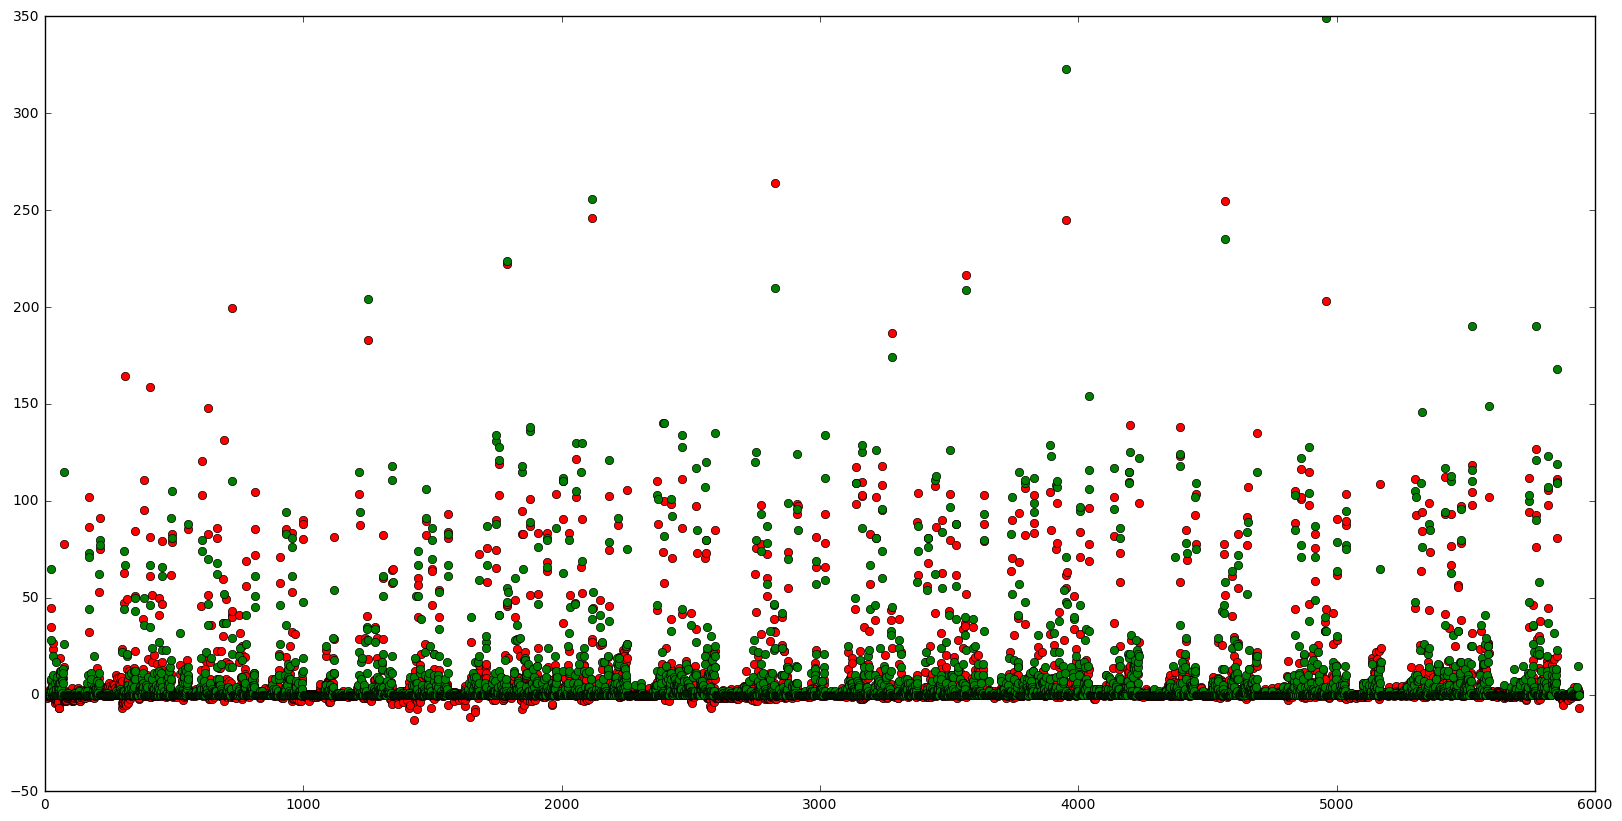

In [208]:
plt.figure(figsize=(20,10))
x = np.arange(0, len(xgboost_predict_proba))
plt.plot(x, xgboost_predict_proba, 'ro', x, dvalid.get_label(), 'go')

In [209]:
res = X_test.copy()
res['actual'] = y_test.values.copy()
res['predictions'] = [int(x) for x in xgboost_predict_proba]
for i in range(0, len(res.predictions)):
    if res.predictions.values[i] < 0:
        res.predictions.values[i] = 0
res.tail(125)

,FlightID,Code,fltNrDptDt,DptTime,ArrTime,flightNrSf,segment,DayOfWeekDpt,WeekOfMonth,MonthDpt,QuarterDpt,YearDpt,DayOfWeeArr,WeekOfMonthArr,MonthArr,QuarterArr,YearArr,Holiday,actual,predictions
118670,113574,2,2017-03-31,20,7,0,1,4,5,3,1,2017,5,1,4,2,2017,0,20.0,15
118671,113574,3,2017-03-31,20,9,0,2,4,5,3,1,2017,5,1,4,2,2017,0,10.0,8
118672,113574,0,2017-03-31,20,9,0,2,4,5,3,1,2017,5,1,4,2,2017,0,37.0,44
118673,113574,1,2017-03-31,20,9,0,2,4,5,3,1,2017,5,1,4,2,2017,0,123.0,105
118674,113574,2,2017-03-31,20,9,0,2,4,5,3,1,2017,5,1,4,2,2017,0,107.0,98
118675,113574,3,2017-03-31,3,7,0,3,5,1,4,2,2017,5,1,4,2,2017,0,0.0,0
118676,113574,0,2017-03-31,3,7,0,3,5,1,4,2,2017,5,1,4,2,2017,0,0.0,0
118677,113574,1,2017-03-31,3,7,0,3,5,1,4,2,2017,5,1,4,2,2017,0,0.0,0
118678,113574,2,2017-03-31,3,7,0,3,5,1,4,2,2017,5,1,4,2,2017,0,0.0,0
118679,113574,3,2017-03-31,3,9,0,4,5,1,4,2,2017,5,1,4,2,2017,0,0.0,0


In [210]:
res.to_excel("whole_results_60.xls")

C:\Anaconda\lib\site-packages\xlwt\ExcelFormulaLexer.py:53: DeprecationWarning: LOCALE flag with a str pattern is deprecated. Will be an error in 3.6
  VERBOSE+LOCALE+IGNORECASE)


In [211]:
len(unique(res.fltNrDptDt))

28

In [212]:
res_s = pd.DataFrame(columns = ("FlightID", "Code", "Date", "FltNr", "actual", "predictions"))
count = 0
for flightID in unique(res.FlightID.values):
    for code in unique(res.Code[res.FlightID == flightID].values):
        date = res.fltNrDptDt[res.FlightID == flightID][res.Code == code].values[0]
        fltNr = res.flightNrSf[res.FlightID == flightID][res.Code == code].values[0]
        res_s.loc[count] = (flightID, code, date, fltNr, sum(res.actual[res.FlightID == flightID][res.Code == code].values), sum(res.predictions[res.FlightID == flightID][res.Code == code].values))
        count += 1

In [213]:
res_s.head(50)

,FlightID,Code,Date,FltNr,actual,predictions
0,44319.0,0.0,2017-03-27,0.0,39.0,37.0
1,44319.0,1.0,2017-03-27,0.0,99.0,101.0
2,44319.0,2.0,2017-03-27,0.0,76.0,66.0
3,44319.0,3.0,2017-03-27,0.0,10.0,4.0
4,44438.0,1.0,2017-03-27,1.0,73.0,86.0
5,44438.0,2.0,2017-03-27,1.0,96.0,101.0
6,44438.0,4.0,2017-03-27,1.0,108.0,111.0
7,44576.0,1.0,2017-03-27,7.0,34.0,24.0
8,44576.0,2.0,2017-03-27,7.0,13.0,18.0
9,44576.0,4.0,2017-03-27,7.0,194.0,248.0


In [214]:
res_s.to_excel("results_60.xls")

In [ ]:
plt.figure(figsize=(20,10))
x = np.arange(0, len(res_s[:int(len(res_s) * 0.2)]))
plt.plot(x, res_s[:int(len(res_s) * 0.2)].actual, 'ro', x, res_s[:int(len(res_s) * 0.2)].predictions, 'go')

In [ ]:
for code in unique(res_s.Code):
    plt.plo
    break

## Тренировка на полных данных

In [ ]:
dtrain_full = xgb.DMatrix(pd.concat([X_train, X_test]), pd.concat([y_train, y_test]))

In [ ]:
xgbCvResult = xgb.cv(params, dtrain_full, num_boost_round=1000, early_stopping_rounds=25, nfold=10, metrics=["logloss"], verbose_eval=True)

In [ ]:
plot(range(xgbCvResult.shape[0]), xgbCvResult['test-logloss-mean'])
plot(range(xgbCvResult.shape[0]), xgbCvResult['train-logloss-mean'])

In [ ]:
best_num_round = np.argmin(xgbCvResult['test-logloss-mean'])
print(best_num_round)

In [ ]:
bestXgb = xgb.train(params, dtrain_full, best_num_round)

In [ ]:
version = 2

In [ ]:
def write_to_submission_file(predicted_labels, out_file):
    predicted_df = pd.DataFrame(predicted_labels)
    predicted_df.to_csv(out_file, sep=',', header=False, index=False)


xgboost_predict_proba = bestXgb.predict(dtest)
write_to_submission_file(xgboost_predict_proba,
                         out_file='results/result' + str(version) + '.csv')